# Example Segmentation: uncinate fasciculus

NOTE:  This segmentation is taken almost verbatim from a [recent version of the matlab-version of WMA segmentation](https://github.com/DanNBullock/wma_tools/blob/53a4d99b68b832257c55d5f1320dc7266cc8c270/Segmentations/bsc_segmentAntPostTracts_v4.m#L76-L207).

## Beginning with practical considerations and limitations

Before truly beginning the segmentation of the [Uncinate Fasciculus](https://en.wikipedia.org/wiki/Uncinate_fasciculus), there's some setup that we need to do.  Among these steps are the loading of the relevant atlas and candidate tractome(s).  Astute observers may note that the loading process we use here is decidedly more... convoluted than normal.  This is due to the use of a workaround related to github's limitation of a 100 MB file size limit.  As such, we'll be loading up 4 individual sub tractomes--divided up by streamline length--and then we'll combine them into one.  As a further note, traditionally when we segment we want to have a very rich tractome to segment from so that our segmented tracts can be as full as possible.  In this case though, we are somewhat constrained by our medium, and so the tracts that we segment will be _significantly_ less full than they would typically be. 

One additional consideration to keep in mind is the length of the target tract.  Traditional tractography generation methods have a very low minimum streamline length (e.g. 10 mm).  Due to the stochastic nature of streamline generation, it is more likely to generate small streamlines than it is to generate long ones, because each additional node increases the probability that the node is "not viable" and thus the streamline fails to complete the generation process (an example of a [conjunct probability](https://en.wikipedia.org/wiki/Conditional_probability)).  However, we aren't looking for just any streamline, we are looking for a streamline which could be a member of the Uncinate Fasciculus.  As such, we know the general range of streamlines we would be looking for (~40 to 100 mm).  This is something to keep in mind when generating one's candidate tractome:  **in most cases, for major white matter tracts, shorter streamlines will not contribute to better segmentation outcomes**.  Instead, they will simply add to the file size of the tractogram and increase computation time.

Lets move to this piecewise loading process.

In [1]:
#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
import pandas as pd
import seaborn as sns
#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#establish path to the 
wma_toolsDirPath=os.path.join(gitRepoPath,'wma_pyTools')   

#change to the wma_tools path, load the function set, then change back to the top directory
os.chdir(wma_toolsDirPath)
import WMA_pyFuncs
os.chdir(gitRepoPath)

import nibabel as nib
import numpy as np

grossAnatomyPath=os.path.join(gitRepoPath,'exampleData','GrossAnatomyLookup.csv')

grossAnatTable=pd.read_csv(grossAnatomyPath)
#load the atlas
atlasPath=os.path.join(gitRepoPath,'exampleData','parc.nii.gz')
#load it as an object
atlasImg = nib.load(atlasPath)


#get and copy the data
grossAnatAtlas=atlasImg.get_fdata().copy()
#get the labels to iterate over
uniqueAtlasEntries=np.unique(atlasImg.get_fdata()).astype(int)
#get the unique 
grossAnatList=grossAnatTable['GrossAnat'].unique()
#iterate across unique label entries
for iLabels in range(len(uniqueAtlasEntries)):
    #print(np.isin(grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]],grossAnatList))
    #replace the current uniqueAtlasEntries value with the label corresponding to the gross anat category
    currentLabelReNum=np.where(np.isin(grossAnatList,grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]]))
    grossAnatAtlas[atlasImg.get_fdata()==uniqueAtlasEntries[iLabels]]=currentLabelReNum[0]
#set the gross anatomy nifti
grossAnatNifti=nib.Nifti1Image(grossAnatAtlas, atlasImg.affine, atlasImg.header)  

#now lets do the same thing again but for entire hemispheres
#get and copy the data
hemisphereAtlas=atlasImg.get_fdata().copy()
#get the labels to iterate over
uniqueAtlasEntries=np.unique(atlasImg.get_fdata()).astype(int)
#get the unique 
hemisphereList=grossAnatTable['Hemi'].unique()
#iterate across unique label entries
for iLabels in range(len(uniqueAtlasEntries)):
    #print(np.isin(grossAnatTable['GrossAnat'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]],grossAnatList))
    #replace the current uniqueAtlasEntries value with the label corresponding to the gross anat category
    currentLabelReNum=np.where(np.isin(hemisphereList,grossAnatTable['Hemi'].loc[grossAnatTable['#No.']==uniqueAtlasEntries[iLabels]]))
    hemisphereAtlas[atlasImg.get_fdata()==uniqueAtlasEntries[iLabels]]=currentLabelReNum[0]
#set the gross anatomy nifti
hemisphereNifti=nib.Nifti1Image(hemisphereAtlas, atlasImg.affine, atlasImg.header)  

# load the tractography file into the streamsObjIN variable
#smallTractogramPath=os.path.join(gitRepoPath,'exampleData','smallTractogram.tck')
TractogramPath1='/Users/plab/Downloads/30to50mmtrack.tck'
TractogramPath2='/Users/plab/Downloads/50to70mmtrack.tck'
TractogramPath3='/Users/plab/Downloads/70to100mmtrack.tck'

streamsObjIN1=nib.streamlines.load(TractogramPath1)
streamsObjIN2=nib.streamlines.load(TractogramPath2)
streamsObjIN3=nib.streamlines.load(TractogramPath3)

#get tractogram from the Tck holder
allStreams=np.concatenate((streamsObjIN1.streamlines[:],streamsObjIN2.streamlines[:],streamsObjIN3.streamlines[:]))

sourceTractogram= nib.streamlines.tractogram.Tractogram(streamlines=allStreams,  affine_to_rasmm=streamsObjIN1.header['voxel_to_rasmm'])


from dipy.tracking import utils
#segment tractome into connectivity matrix from parcellation
M, grouping=utils.connectivity_matrix(sourceTractogram.streamlines, grossAnatNifti.affine, \
                        label_volume=grossAnatNifti.get_fdata().astype(int), \
                        return_mapping=True,\
                        symmetric=False,\
                        mapping_as_streamlines=False)

#segment the tractome into a hemisphere based map (only a 3x3 matrix really)
hemiM, hemiGrouping=utils.connectivity_matrix(sourceTractogram.streamlines, hemisphereNifti.affine, \
                        label_volume=hemisphereNifti.get_fdata().astype(int), \
                        return_mapping=True,\
                        symmetric=False,\
                        mapping_as_streamlines=False)

## Establishing the category

The Uncinate is definitionally a fronto-temporal tract.  Although we could be more specific than this, and note that it occupies the anterior temporal poles, we needn't actually be this specific for the purposes of applying a categorical segmentation.  Instead, we can simply use the existing fronto-temporal category.

Below, we'll visualize the relevant category.

In [2]:
#quick and dirty tractogram subsetter by Brad Caron
#https://github.com/bacaron
def extractSubTractogram(sourceTractogram,indexes):
    #import relevant package
    import nibabel as nib
    #extrect the desired streamlines into a new streamline object
    streamlines = sourceTractogram.streamlines[indexes]
    #establish tractogram object
    out_tractogram = nib.streamlines.tractogram.Tractogram(streamlines)
    #adjust the relevant header fields
    #don't bother for now, header is only relevant to Tck file
    #for headerFields in ['total_count','count','nb_streamlines']:
        #nb_streamlines is an int, whereas the others are strings, for some reason
    #    if headerFields == 'nb_streamlines':
    #        out_tractogram.header[headerFields] = len(streamlines)
    #    else:
    #        out_tractogram.header[headerFields] = '%s' %len(streamlines)
    return out_tractogram

#interactive plotting via niwidgets?  
#widget within a widget doesn't seem to work
def plotParcellationConnectionWidget(subTractogram):
    #import widget
    from niwidgets import StreamlineWidget
    #set widget object
    
    sw = StreamlineWidget(streamlines=subTractogram)
    #set plotting characteristics
    style = {'axes': {'color': 'red',
                  'label': {'color': 'white'},
                  'ticklabel': {'color': 'white'},
                  'visible': False},
         'background-color': 'black',
         'box': {'visible': False}}
    #plot it
    sw.plot(display_fraction=1, width=1000, height=1000, style=style, percentile=0)

def plotTract(tractIn):
    import numpy as np
    from dipy.viz import window, actor
    renderer = window.Scene()
    stream_actor = actor.line(tractIn)
    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #               focal_point=(113.30, 128.31, 76.56),
    #                view_up=(0.18, 0.00, 0.98))
    %matplotlib inline
    renderer.add(stream_actor)
    
    window.show(renderer, size=(600, 600), reset_camera=True)

def updateFunction(regionIndex1,regionIndex2):
    currentRenumberIndex1=regionIndex1    
    currentRenumberIndex2=regionIndex2   
 
    
    #check to make sure this pairing is actually in the connections
    if np.logical_or((currentRenumberIndex1,currentRenumberIndex2) in grouping.keys(),(currentRenumberIndex1,currentRenumberIndex2) in grouping.keys()): 
        #if they are both there do it (dipy method may preclude this)
        if np.logical_and((currentRenumberIndex1,currentRenumberIndex2) in grouping.keys(),(currentRenumberIndex1,currentRenumberIndex2) in grouping.keys()): 
            currentIndexes=np.concatenate((np.asarray(grouping[currentRenumberIndex1,currentRenumberIndex2]),np.asarray(grouping[currentRenumberIndex2,currentRenumberIndex1]))).astype(int)
        elif (currentRenumberIndex1,currentRenumberIndex2) in grouping.keys():
            currentIndexes=grouping[currentRenumberIndex1,currentRenumberIndex2]
        elif (currentRenumberIndex2,currentRenumberIndex1) in grouping.keys():
            currentIndexes=grouping[currentRenumberIndex2,currentRenumberIndex1]
        #there are no other potential cases
        subTractogram=extractSubTractogram(sourceTractogram,currentIndexes)
        %matplotlib inline
        plotParcellationConnectionWidget(subTractogram.streamlines)
    else:
        print('connection not present')

dropDownList=list(zip(grossAnatList, range(len(grossAnatList))))

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Dropdown

#establish interactivity
interact(updateFunction, 
         regionIndex1=Dropdown(options=dropDownList, value=9, description="region1"), 
         regionIndex2=Dropdown(options=dropDownList, value=12, description="region2"),
        )
#create a boolean vector for the category outputs
categoryBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)
leftBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)
rightBool=np.zeros(len(sourceTractogram.streamlines),dtype=int)

categoryBool[np.union1d(grouping[9,12],grouping[12,9])]=True
#1 is left hemisphere, 2 is right, 0 is both/neither/midline
leftBool[hemiGrouping[1,1]]=True
rightBool[hemiGrouping[2,2]]=True

interactive(children=(Dropdown(description='region1', index=9, options=(('unknown', 0), ('wm', 1), ('ventricle…

## Establish more specific endpoint criteria (loosely)
In order to prevent certain spurious streamlines (potentially implausible, and certainly not part of the Uncinate) we can include some additional segmentation logic to exclude these streamlines *while also not being so strict as to make the segmentation [brittle](https://en.wikipedia.org/wiki/Brittle_system) or [overdetermined](https://en.wikipedia.org/wiki/Overdetermined_system)*.  Two of these loose endpoint criteria will be necessary for the Uncinate.  Given that we require the posterior cluster of streamlines to be located in the anterior temporal region we can implement criteria relative to the dorso-ventral axis and the rostro-caudal axis. 
 
###  Dorso-ventral endpoint criteria

#### Dorso-ventral criteria - segmentation logic

In general, the endpoints of the Uncinate are fairly low in the brain.
Furthermore, we note that the arc of the Uncinate occurs relatively close to the amygdala.  Because the streamlines of the uncinate approach from the ventral side of the [amygdala](https://en.wikipedia.org/wiki/Amygdala) (as they then proceed anteriorly to the frontal lobes), and reach their apex at around the top of the amygdala, it is necessarily the case that at least one endpoint of these streamlines (namely the posterior/inferior endpoint) is _below_ the top of the amygdala.  Therefore, it is logically necessary that it is *not* the case that both streamline endpoints are superior to the top of the amygdala (or else it couldn't engage in the arcing behavior).  Lets translate this into segmentation logic.

First we will begin by generating a plane from the top of the amygdala.  Then we find all streamlines that have **both** streamline endpoints above this plane (we'll negate this criteria later, to adhere to our logic). Note, using the plane in this way is different than requiring neither streamline to be above this plane.  **This logical operation still permits maximally one endpoint per streamline to be above this plane** .

[Text(0, 0.5, 'category'),
 None,
 Text(0.5, 0, 'streamline count (log)'),
 Text(0.5, 1.0, 'effect of endpoint dorso-ventral criteria')]

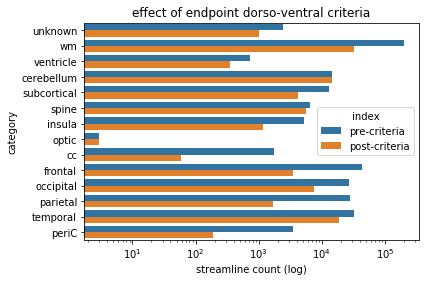

In [3]:
# Begin by generating a plane from the top of the amygdala
amygdalaTopPlane=WMA_pyFuncs.planarROIFromAtlasLabelBorder(atlasImg,18, 'superior')

# find all streamlines that have both streamline endpoints above this plane (we'll negate this criteria later, to generate our logic)
bothAboveAmygBool=WMA_pyFuncs.applyEndpointCriteria(sourceTractogram.streamlines,amygdalaTopPlane,'superior','both')

#compute the effect on the connectivity matrix
bothAboveAmygLogicMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,np.logical_not(bothAboveAmygBool))
#sum across columns and make an array
compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(bothAboveAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of endpoint dorso-ventral criteria')

####  Dorso-ventral criteria - observations

From the bar plot above, we see that the application of this criteria impacted some categories of streamlines more than others.  Note that, when computing the impact of this criteria we negated the output (using [np.logical_not](https://numpy.org/doc/stable/reference/generated/numpy.logical_not.html)) just as we will do when we actually utilize this output boolean vector to compute the final segmentation.  The parietal, and frontal, and occipital categories all exhibit a reduction in streamlines, whereas the temporal category appears to maintain most of its members (as would be expected for the more ventral structure).

### Rostro-caudal endpoint criteria

####  Rostro-caudal criteria - segmentation logic

In general, the endpoints of the Uncinate are fairly *anterior* in the brain as we noted above, the arc of the Uncinate occurs relatively close to the amygdala. This is true of the rostro-caudal axis as well. The streamlines of the Uncinate have all begun to arc forward anterior of the posterior of the border of the amygdala.  A consequence, similar to the one noted (in bold) in the dorso-ventral criteria discussion, is that it is *not* the case that both endpoints are posterior of this posterior amygdala border.  Lets translate this into segmentation logic.

We will begin by generating a plane from the posterior of the amygdala.  Next, we will use this to find all streamlines that have both streamline endpoints posterior to this plane (we'll negate this criteria later, to adhere to our logic). Note, this is different than requiring _neither_ streamline to be anterior to this plane.  **This logical operation still permits maximally one endpoint per streamline to be posterior to
this plane**.

[Text(0, 0.5, 'category'),
 None,
 Text(0.5, 0, 'streamline count (log)'),
 Text(0.5, 1.0, 'effect of endpoint rostro-caudal criteria')]

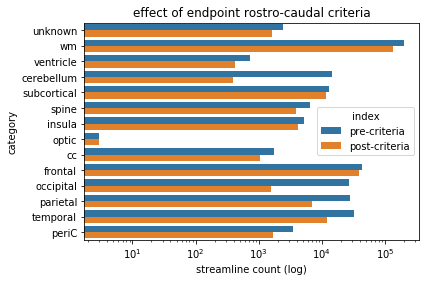

In [4]:
# Begin by generating a plane from the top of the amygdala
amygdalaPosteriorPlane=WMA_pyFuncs.planarROIFromAtlasLabelBorder(atlasImg,18, 'posterior')

# find all streamlines that have both streamline endpoints above this plane (we'll negate this criteria later, to generate our logic)
bothPosteriorAmygBool=WMA_pyFuncs.applyEndpointCriteria(sourceTractogram.streamlines,amygdalaPosteriorPlane,'posterior','both')

#compute the effect on the connectivity matrix
bothPostAmygLogicMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,np.logical_not(bothPosteriorAmygBool))
#sum across columns and make an array
compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(bothPostAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of endpoint rostro-caudal criteria')

####  Rostro-caudal criteria - observations

As with the dorso-ventral criteria, we've negated the boolean vector once more, such that we are considering those streamlines which **do not** have both endpoints posterior to the amygdala.

The predominantly impacted categories in this instance are the occipital and cerebellar categories (and to a lesser extent, parietal).  This is consistent with our intent in using this criteria, because we are excluding streamlines confined to the posterior of the brain.

## Other anatomical criteria

### midpoint rostro-caudal criteria 

#### midpoint rostro-caudal criteria - segmentation logic

If the arc of the Uncinate occurs anterior to the posterior border of the amygdala, it stands to reason that the midpoint of those streamlines would also occur anterior to this border.  Even in the case of more [sigmoidally](https://en.wikipedia.org/wiki/Sigmoid_function) shaped streamlines (as opposed to u or j shaped), which do occur and have their endpoints potentially posterior to the posterior of the amygdala, the midpoint would still be anterior of this border if the anterior endpoint is to terminate in the anterior frontal lobes.  This can rather straightforwardly be translated into segmentation logic.

[Text(0, 0.5, 'category'),
 None,
 Text(0.5, 0, 'streamline count (log)'),
 Text(0.5, 1.0, 'effect of midpoint rostro-caudal criteria')]

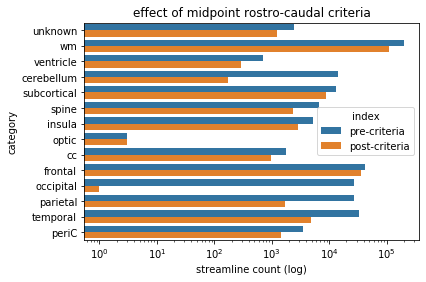

In [5]:
# Now we find all streamlines that the midpoint anterior of the same posterior amigdala plane we made earlier.
midpointAntOfPosteriorAmygBool=WMA_pyFuncs.applyMidpointCriteria(sourceTractogram.streamlines,amygdalaPosteriorPlane,'anterior');

#compute the effect on the connectivity matrix
midpointAntAmygLogicMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,midpointAntOfPosteriorAmygBool)
#sum across columns and make an array
compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(midpointAntAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of midpoint rostro-caudal criteria')

#### #### midpoint rostro-caudal criteria - observations

Note that, in this case, we **did not** negate the outcome of the boolean vector.  This is because the output we obtained (midpoints anterior of the posterior amygdala) **is** what we want.  The primarily impacted categories are occipital and cerebellar (by a wide margin), but also parietal and temporal, to a lesser extent.

### posterior non-traversal criteria

#### posterior non-traversal criteria - segmentation logic

As it should have been clear by now the category segmentation is insufficient to isolate the Uncinate.  You can refer back to the category visualization from earlier in this chapter to confirm this for yourself.  Note that the majority of the non-Uncinate streamlines in the fronto-temporal category appear to be streamlines of the [Arcuate Fasciculus](https://en.wikipedia.org/wiki/Arcuate_fasciculus).  How can we exclude these streamlines?  By applying a plane that selectively targets the Arcuate streamlines.

Subcortical structures, like the [Thalamus](https://en.wikipedia.org/wiki/Thalamus) (and amygdala), tend to be relatively invariant in their location across subjects.  This is likely due to their proximity to the [anterior commissure](https://en.wikipedia.org/wiki/Anterior_commissure) (which serves as a central orientation point) and their comparative cross-subject [homology](https://en.wikipedia.org/wiki/Homology_(biology)) (as compared to the gyri and sulci of the cortex).  This is fortunate for us, because it looks like all of the Arcuate-like streamlines extend *past* the posterior of the thalamus.  Lets generate a planar ROI that we can use as an exclusion criterion.

[Text(0, 0.5, 'category'),
 None,
 Text(0.5, 0, 'streamline count (log)'),
 Text(0.5, 1.0, 'effect of posterior non-traversal criteria')]

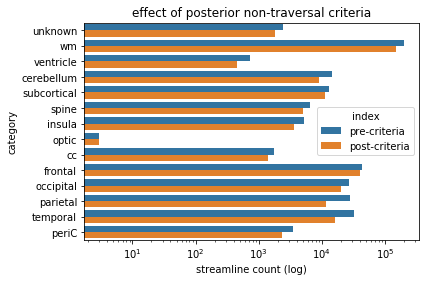

In [6]:
posteriorThalPlane=WMA_pyFuncs.planarROIFromAtlasLabelBorder(atlasImg,10, 'posterior')

posteriorThalBool=WMA_pyFuncs.applyNiftiCriteriaToTract(sourceTractogram.streamlines, posteriorThalPlane, True, 'any')

posteriorThalLogicMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,np.logical_not(posteriorThalBool))
#sum across columns and make an array
compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(posteriorThalLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of posterior non-traversal criteria')

#### posterior non-traversal criteria - observations

Interestingly, this criteria doesn't appear to have much of an effect.  Basically all we have done is excluded any streamline that crosses a specific plane (the posterior border of the thalamus), and as it turns out the overwhelming majority of streamlines don't do this.  In truth though, this criteria was targeting a very specific structure: the [Arcuate Fasciculus](https://en.wikipedia.org/wiki/Arcuate_fasciculus), which was partially visible in the fronto-temporal category at the start of this chapter.  Only a limited number of streamlines correspond to this, but it's nonetheless important that we exclude them, in order to get a good segmentation.

## Combine criteria and visualize

Below, we will selectively apply the criteria we have created and visualize the output.  You'll notice that this is a different widget than we have used previously.  To toggle a specific criteria from the list press control and click on the associated criteria name.  You can also shift click to select a range of criteria at once.  Also note that, because this is a widget within a widget, this visualization may take a moment to update when you change options.

The default criteria selection for this visualization results in the plotting of the right Uncinate Fasciculus.  You can switch between the left and right hemisphere criteria, but note that if both are activated then no streamlines will be plotted (by definition, there are no streamlines that are in both hemispheres that are also contained entirely within a single hemisphere).  It is interesting to observe just how close the pairing of the category criteria and the posterior traversal criteria get to segmenting this tract, however additional criteria are necessary to exclude those few fibers which remain dorsal to the Uncinate.

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import SelectMultiple

criteriaList=['Dorso-ventral endpoint','Rostro-caudal endpoint','Rostro-caudal midpoint','Posterior non-traversal','Category','Right hemisphere','Left hemisphere']

def interpretCriteria(x):
    #might do some weird stuff for equal values
    import numpy as np
    return {
            'Dorso-ventral endpoint': np.logical_not(bothAboveAmygBool),
            'Rostro-caudal endpoint': np.logical_not(bothPosteriorAmygBool),
            'Rostro-caudal midpoint':  midpointAntOfPosteriorAmygBool,
            'Posterior non-traversal': np.logical_not(posteriorThalBool),
            'Category': categoryBool,
            'Right hemisphere': rightBool,
            'Left hemisphere': leftBool,
        }[x]

def updateSeg(commandIn):
    import numpy as np
    if len(commandIn)>0:
        criteriaOutArray=np.asarray(list(map(interpretCriteria,commandIn)))
        currentIndexes=np.concatenate(np.where(np.all(criteriaOutArray,axis=0)))
        
        subTractogram=extractSubTractogram(sourceTractogram,currentIndexes)
        %matplotlib inline
        if len(subTractogram.streamlines)>0:
            plotParcellationConnectionWidget(subTractogram.streamlines)
        else:
            print('no streamlines meet specified criteria')

#establish interactivity
interact(updateSeg, commandIn=SelectMultiple(options=criteriaList,value=criteriaList[0:-1], description='criteria',continuous_update=False,disabled=False))



interactive(children=(SelectMultiple(description='criteria', index=(0, 1, 2, 3, 4, 5), options=('Dorso-ventral…

<function __main__.updateSeg(commandIn)>

## Quantitative assessment

In the plot below, you'll be able to select whatever combination of criteria you chose and view their impact on the overall count of streamlines in each category.  As was discussed in the chapter on categorical segmentations, you'll notice that the application of the category-specific criteria has the largest effect.  However, designing segmentations isn't just about quantity (of streamlines excluded) it's also about quality, which is why we need the other criteria as well.

In [8]:
def barPlotCriteria(commandIn):
    import numpy as np
    import seaborn as sns
    if len(commandIn)>0:
        criteriaOutArray=np.asarray(list(map(interpretCriteria,commandIn)))
        
        combinedCriteriaMatrix=WMA_pyFuncs.maskMatrixByBoolVec(grouping,np.all(criteriaOutArray,axis=0))
        #sum across columns and make an array
        compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(combinedCriteriaMatrix,axis=1)))
        #use pandas to create a dataframe for this
        comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
        meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

        criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
        criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of selected criteria')
    else:
        print('no commands entered')
#establish interactivity
interact(barPlotCriteria, commandIn=SelectMultiple(options=criteriaList,description='criteria',disabled=False))

interactive(children=(SelectMultiple(description='criteria', options=('Dorso-ventral endpoint', 'Rostro-caudal…

<function __main__.barPlotCriteria(commandIn)>

## Designing for edge cases

In many cases, after the application of only a few criteria, most of the non-target streamlines will be removed **however** aberrant streamlines may still remain.  In order to remove these, the inclusion of additional, carefully targeted criteria should be applied.  These criteria should be designed in such a way that they are generalizable to all subjects and would be an accurate criteria for the target tract **whether or not** the aberrant streamlines are present in a particular case.  This is why, in some cases, it may appear that "pointless" criteria have been included: in previous cases and/or in other subjects, aberrant streamlines needed to be excluded.  Unfortunately this turns out to be one of the tricker (and unending) parts of designing segmentations.

As was noted in the section on biological plausibility, the more biologically plausible your input tractome is, the easier time you'll have segmenting.  This is because, as the traversal patterns and general architecture of streamlines becomes less constrained, more and more edge cases with unusual or aberrant streamlines will occur.  As such, it is difficult to know when a segmentation has been "finalized"--it's always a possibility that you will encounter a particularly wild or unruly tractome with unexpected streamlines that need to be contended with.  A particularly devious individual will almost always be able to come up with a counter example streamline which meets your currently implemented criteria, but still doesn't correspond to your structure of interest. Generally speaking though, it's possible to develop broadly effective segmentations using a finite (typically around six or so) number of criteria.

##  Moving on

In the next chapter we will take a look at another example segmentation, this time of the [inferior fronto-occipital fasciculus (IFOF)](https://en.wikipedia.org/wiki/Occipitofrontal_fasciculus)